In [1]:
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
from PIL import Image
from torch.autograd import Variable

### Train

In [2]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print ('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            num_correct = 0
            
                
            for data, labels in dataloaders[phase]:
                data = data.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(data)
                    loss = criterion(output, labels)
                    _, preds = torch.max(output.data, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item()*data.size(0)
                num_correct += torch.sum(preds == labels.data)
                del data, labels, output, preds
                torch.cuda.empty_cache()
                #break
            epoch_loss =  running_loss / dataSizes[phase]
            epoch_acc = num_correct.double() / dataSizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) 
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            #break    
        print()
        print('='*70) 
        print()
        #break
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}mins {:.0f}secs'.format(time_elapsed // 60, time_elapsed % 60)) 
    print('Best accuracy {:.4f}'.format(best_acc * 100))
    
    model.load_state_dict(best_model_wts) #load it again to return it at the main function
    #model.save_state_dict('model_name.pt')
    
    return model, train_losses, train_acc, val_losses, val_acc   

In [4]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize((256, 256)),
        transforms.RandomRotation((90, 180)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/new_dataset/'
image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(image_dataset[x],
                             batch_size=16,
                             shuffle=True,
                            num_workers=4)
              for x in ['train', 'val', 'test']}
dataSizes = {x: len(image_dataset[x]) for x in ['train', 'val', 'test']}
class_names = image_dataset['train'].classes

'''train_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/train/')
val_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/val/')
test_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/test/')

batch_size = 16
lr = 0.001

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
'''

"train_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/train/')\nval_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/val/')\ntest_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/test/')\n\nbatch_size = 16\nlr = 0.001\n\ntrain_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)\nval_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)\ntest_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)\n"

### Test

In [5]:
def test_model(model, criterion, optimizer, scheduler, num_epochs):
    model.eval()
    num_correct = 0
    test_losses = []
    running_loss = 0.0
    accuracy = 0
    for data, labels in dataloaders['test']:
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        _,preds = torch.max(output.data, 1)
        running_loss += loss.data[0]*data.size(0)
        num_correct += torch.sum(preds == labels.data)
        true.extend(labels.data.cpu().numpy().tolist())
        pred.extend(preds.cpu().numpy().tolist())
        
    accuracy = num_correct/dataSizes['test']
    return accuracy

### Confusion matrix

In [6]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_conf_matrix(y_test, y_pred, class_names):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    print('CCR = {}'.format(np.trace(cnf_matrix) / len(y_test)))
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.show()

### Main (Finetuning)

model is downloaded successfully
Epoch 0/59
----------
train Loss: 0.7260 Acc: 0.5190
val Loss: 0.6874 Acc: 0.5572


Epoch 1/59
----------
train Loss: 0.7180 Acc: 0.5177
val Loss: 0.6970 Acc: 0.4974


Epoch 2/59
----------
train Loss: 0.7167 Acc: 0.4972
val Loss: 0.6892 Acc: 0.4957


Epoch 3/59
----------
train Loss: 0.7044 Acc: 0.5137
val Loss: 0.7504 Acc: 0.4801


Epoch 4/59
----------
train Loss: 0.7015 Acc: 0.5277
val Loss: 0.7093 Acc: 0.4974


Epoch 5/59
----------
train Loss: 0.6957 Acc: 0.5273
val Loss: 0.7087 Acc: 0.5087


Epoch 6/59
----------
train Loss: 0.6977 Acc: 0.5277
val Loss: 0.7019 Acc: 0.5312


Epoch 7/59
----------
train Loss: 0.6899 Acc: 0.5351
val Loss: 0.7061 Acc: 0.5303


Epoch 8/59
----------
train Loss: 0.6892 Acc: 0.5404
val Loss: 0.6915 Acc: 0.5503


Epoch 9/59
----------
train Loss: 0.6851 Acc: 0.5497
val Loss: 0.6971 Acc: 0.5312


Epoch 10/59
----------
train Loss: 0.6840 Acc: 0.5640
val Loss: 0.7074 Acc: 0.5399


Epoch 11/59
----------
train Loss: 0.6827 

train Loss: 0.6739 Acc: 0.5836
val Loss: 0.6769 Acc: 0.5797


Epoch 54/59
----------
train Loss: 0.6763 Acc: 0.5808
val Loss: 0.6778 Acc: 0.5832


Epoch 55/59
----------
train Loss: 0.6736 Acc: 0.5861
val Loss: 0.6831 Acc: 0.5789


Epoch 56/59
----------
train Loss: 0.6744 Acc: 0.5883
val Loss: 0.6838 Acc: 0.5780


Epoch 57/59
----------
train Loss: 0.6740 Acc: 0.5914
val Loss: 0.6767 Acc: 0.5815


Epoch 58/59
----------
train Loss: 0.6747 Acc: 0.5855
val Loss: 0.6772 Acc: 0.5962


Epoch 59/59
----------
train Loss: 0.6747 Acc: 0.5764
val Loss: 0.6961 Acc: 0.5754


Training complete in 223mins 16secs
Best accuracy 59.6187


/home/eslam/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


CCR = 0.6003568242640499
[[336 224]
 [224 337]]


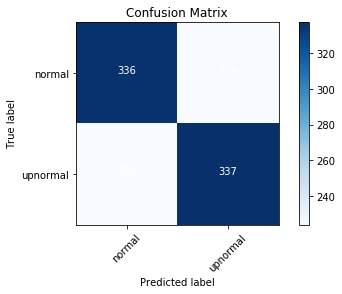

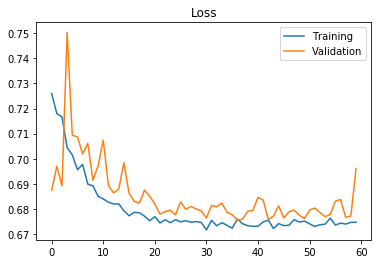

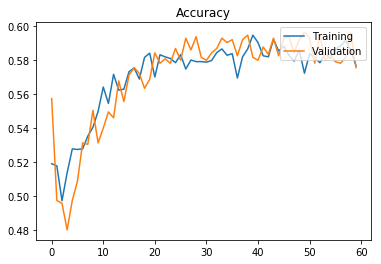

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = models.resnet18(pretrained=True)
print('model is downloaded successfully')
model.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
class_names = ['normal','upnormal']
true = []
pred = []
accuracy =0
num_epochs = 60

mymodel, train_losses, train_acc, val_losses, val_acc=train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)
accuracy = test_model(mymodel, criterion, optimizer, scheduler, num_epochs = num_epochs)
plot_conf_matrix(true, pred, class_names)

### plotting ###
epochsRange = np.array(range(num_epochs))
plt.plot(epochsRange, train_losses, label='Training')
plt.plot(epochsRange, val_losses, label='Validation')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(epochsRange, train_acc, label='Training')
plt.plot(epochsRange, val_acc, label='Validation')
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.show()

### Main (Convnet as feature extractor)

model is downloaded successfully
Epoch 0/29
----------
train Loss: 0.6971 Acc: 0.5488
val Loss: 0.6805 Acc: 0.5763


Epoch 1/29
----------
train Loss: 0.6669 Acc: 0.6025
val Loss: 0.6299 Acc: 0.6473


Epoch 2/29
----------
train Loss: 0.6578 Acc: 0.6063
val Loss: 0.6487 Acc: 0.6438


Epoch 3/29
----------
train Loss: 0.6563 Acc: 0.6131
val Loss: 0.6588 Acc: 0.6326


Epoch 4/29
----------
train Loss: 0.6614 Acc: 0.6178
val Loss: 0.6482 Acc: 0.6447


Epoch 5/29
----------
train Loss: 0.6412 Acc: 0.6227
val Loss: 0.6275 Acc: 0.6412


Epoch 6/29
----------
train Loss: 0.6411 Acc: 0.6352
val Loss: 0.6355 Acc: 0.6049


Epoch 7/29
----------
train Loss: 0.6252 Acc: 0.6367
val Loss: 0.6195 Acc: 0.6568


Epoch 8/29
----------
train Loss: 0.6255 Acc: 0.6401
val Loss: 0.6298 Acc: 0.6352


Epoch 9/29
----------
train Loss: 0.6251 Acc: 0.6464
val Loss: 0.6329 Acc: 0.6646


Epoch 10/29
----------
train Loss: 0.6285 Acc: 0.6457
val Loss: 0.6229 Acc: 0.6482


Epoch 11/29
----------
train Loss: 0.6222 

/home/eslam/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


CCR = 0.6369313113291704
[[469  91]
 [316 245]]


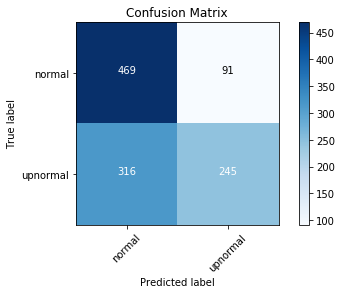

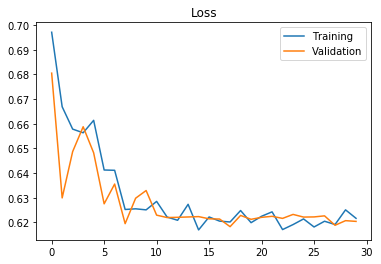

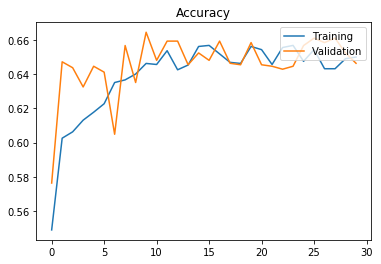

In [10]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
print('model is downloaded successfully')
model_conv.avgpool = nn.AdaptiveAvgPool2d(1)
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

lr = 0.0005
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv.fc.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
class_names = ['normal','upnormal']
true = []
pred = []
accuracy =0
num_epochs = 30

mymodel, train_losses, train_acc, val_losses, val_acc=train_model(model_conv, criterion, optimizer, scheduler, num_epochs=num_epochs)
accuracy = test_model(mymodel, criterion, optimizer, scheduler, num_epochs = num_epochs)
plot_conf_matrix(true, pred, class_names)

### plotting ###
epochsRange = np.array(range(num_epochs))
plt.plot(epochsRange, train_losses, label='Training')
plt.plot(epochsRange, val_losses, label='Validation')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(epochsRange, train_acc, label='Training')
plt.plot(epochsRange, val_acc, label='Validation')
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.show()